In [1]:
import torchvision
import torchvision.transforms as transforms
import torchvision.utils
# from torchvision import datasets

import torch
# import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
# from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
# from torch.autograd import Variable

import os
# import time
# import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
# import PIL.ImageOps

In [2]:
set1 = "F:\\Desktop\\signatures"
set2 = "F:\\Desktop\\sign_data"

path_to_saved_model = "F:\\Desktop\\bentomodel"

In [3]:
def imshow(img, text=None, save=False):
  npimg = img.numpy()
  plt.axis('off')

  if text:
    plt.text(75, 8, text, style='italic', fontweight='bold',
             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

def show_plot(iteration, loss):
  plt.plt(iteration, loss)
  plt.show()

In [4]:
import os

train_dir = set2 + "\\train"
train_csv = set2 + "\\train_data.csv"
test_dir = set2 + "\\test"
test_csv = set2 + "\\test_data.csv"
print(train_csv)

F:\Desktop\sign_data\train_data.csv


In [5]:
class Config():
  train_batch_size = 128
  train_no_epoch = 20

# preprocessing and loading the dataset
class SiameseDataset():
  def __init__(self, train_csv, train_dir, transform=None):
    self.train_df = pd.read_csv(train_csv)
    self.train_df.columns = ['image1','image2','label']
    self.train_dir = train_dir
    self.transform = transform
  
  def __getitem__(self, index):
    img1_path = os.path.join(self.train_dir, self.train_df.iat[index, 0])
    img2_path = os.path.join(self.train_dir, self.train_df.iat[index, 1])

    img0 = Image.open(img1_path)
    img1 = Image.open(img2_path)
    img0 = img0.convert('L')
    img1 = img1.convert('L')

    if self.transform is not None:
      img0 = self.transform(img0)
      img1 = self.transform(img1)
    return img0, img1, torch.from_numpy(np.array([int(self.train_df.iat[index,2])], dtype=np.float32))

  def __len__(self):
    return len(self.train_df)


In [6]:
transform = torchvision.transforms.Compose(
      [torchvision.transforms.Resize((105,105)),
      torchvision.transforms.ToTensor()]
     )

siamese_dataset = SiameseDataset(train_csv, train_dir, transform=transform)

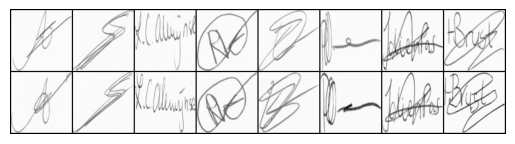

[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [8]:
len(example_batch)

3

In [9]:
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()

    self.cnn1 = nn.Sequential(
        
        nn.Conv2d(1,96,kernel_size=11,stride=1),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001, beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Conv2d(96,256,kernel_size=5,stride=1,padding=2),
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(5,alpha=0.0001, beta=0.75,k=2),
        nn.MaxPool2d(3, stride=2),

        nn.Dropout2d(p=0.3),

        nn.Conv2d(256,384,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),

        nn.Conv2d(384,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        
        nn.MaxPool2d(3, stride=2),
        nn.Dropout2d(p=0.3),
    )

    self.fc1 = nn.Sequential(
        nn.Linear(30976,1024),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=0.5),

        nn.Linear(1024,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,2)
    )

  def forward_once(self, x):
    output = self.cnn1(x)
    output = output.view(output.size()[0],-1)
    output = self.fc1(output)
    return output
  
  def forward(self, input1, input2):
    output1 = self.forward_once(input1)
    output2 = self.forward_once(input2)
    return output1, output2

In [10]:
class ContrastiveLoss(torch.nn.Module):
  def __init__(self, margin=2.0):
    super(ContrastiveLoss, self).__init__()
    self.margin=margin
  
  def forward(self, output1, output2, label):
    euc_dist = F.pairwise_distance(output1, output2)
    loss_contrastive = torch.mean((1-label)*torch.pow(euc_dist,2) + 
                                  (label)*torch.pow(torch.clamp(self.margin - euc_dist, min=0.0), 2))
    return loss_contrastive


In [11]:
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=True,
                              num_workers=2,
                              batch_size=Config.train_batch_size)

In [12]:
if torch.cuda.is_available():
  print('Yes')
  device = 'cuda'
else:
  print('No')
  device = 'cpu'


No


In [13]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [14]:
# from tqdm import tqdm|
import tqdm.notebook as tq

In [15]:
def train():
  print("inside train()")
  counter = []
  loss_history = []
  iteration_number = 0

  for epoch in range(0, 1):
    it = enumerate(train_dataloader, 0)
    print(f'inside inner cycle epoch {epoch}')
    for i, data in tq.tqdm(it):
      print(f'i = {i}')
      img0, img1, label = data
      img0, img1, label = img0.to(device), img1.to(device), label.to(device) 
      optimizer.zero_grad()
      op1, op2 = net(img0, img1)
      loss_contrastive = criterion(op1, op2, label)
      loss_contrastive.backward()
      optimizer.step()
      if i%50 == 0:
        print(f'Epoch number {epoch}\n Current loss {loss_contrastive.item()}')
        iteration_number += 10
        counter.append(iteration_number)
        loss_history.append(loss_contrastive.item())
    return net

In [16]:
import wandb
# wandb.init()

In [ ]:
for epoch in range(0, Config.train_no_epoch):
  print(f'start epoch {epoch}')
  model = train()
  torch.save(model.state_dict(),'model.pt')
  print(f'Model Saved for epoch {epoch}')

start epoch 0
inside train()


In [ ]:
import logging

import bentoml
import joblib

In [ ]:
def save(model, bentoml_name, path):
    """
    save local model to storage with the help of bentoml
    """
    bentoml.pytorch.save(bentoml_name, model, store_as_json_and_weights=True)

    joblib.dump(model, path)

In [ ]:
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load('model.pt'))

In [ ]:
save(model, "bento_sign", path_to_saved_model)

In [ ]:
transform = transforms.Compose(
      [transforms.Resize((105,105)),
      transforms.ToTensor()]
     )

test_dataset = SiameseDataset(test_csv, test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
counter = 0 
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])

for i, data in enumerate(test_dataloader, 0):
  x0, x1, label = data
  concatenated = torch.cat((x0, x1),0)
  op1, op2 = model(x0.to(device), x1.to(device))
  euc_dist = F.pairwise_distance(op1, op2)

  if label==list_0:
    label="Original"
  else:
    label="Forged"

  imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euc_dist.item():.2f} Label: {label}')
  counter+=1
  if counter==20:
    break

In [ ]:
accuracy = 0
counter = 0
correct = 0
for i, data in enumerate(test_dataloader, 0):
  x0, x1, label = data
  op1, op2 = model(x0.to(device), x1.to(device))
  res = torch.abs(op1.to(device) - op2.to(device))
  label = label[0].tolist()
  label = int(label[0])
  result = torch.max(res, 1)[1][0][0].data[0].tolist()
  if label == result:
    correct+=1
  counter+=1

accuracy=(correct/len(test_dataloader)) *100
print(f"Accuracy {accuracy}")

In [ ]:
net

In [ ]:
for i in net.parameters():
  print(i)